## CO2 Forecasting with Time Series

### Background

The analysis is focused on <a href="https://www.statsmodels.org/dev/datasets/generated/co2.html">CO2</a> dataset, 
provided by <a href='http://cdiac.ornl.gov/trends/co2/sio-keel-flask/sio-keel-flaskmlo_c.html'>climate.gov</a> and 
available from **statsmodels** library.

It covers **data preparation**, **data exploration** using **visualization** and **STL decomposition** and **building a 
seasonal ARIMA model** used for producing **one-step ahead**, **dynamic** and **future forecasts**.

The analysis is done in Python, using Numpy and Pandas libraries for data manipulation, Matplotlib and pylab for visualizations.
It also uses statsmodels for building the seasonal ARIMA model.

In [1]:
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as splt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Dataset Description

The dataset is named **Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, USA**. The carbon 
dioxide data on Mauna Loa constitute the longest record of direct measurement. It is part of the datasets available from
**statsmodels library**. 
It contains **2284 observations** which are **CO2 collected samples** from **March 1958 to December 2001**.

**Attribute information**:
- **date**: sample date in YYMMDD format
- **co2**: CO2 Concentration ppmv

### Loading Data - Indexing the Time Series

In [2]:
# Load data using load_pandas() method
# The dates are returned as index
data = sm.datasets.co2.load_pandas()

# The full dataset is available 
# in the data attribute
AirCO2 = data.data

In [3]:
# Print the shape of the dataset 
print(AirCO2.shape)

# Display the first rows
AirCO2.head()

(2284, 1)


,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [4]:
# Display the last rows
AirCO2.tail()

,co2
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3
2001-12-29,371.5


In [5]:
# Check the index of the time series
AirCO2.index

DatetimeIndex(['1958-03-29', '1958-04-05', '1958-04-12', '1958-04-19',
               '1958-04-26', '1958-05-03', '1958-05-10', '1958-05-17',
               '1958-05-24', '1958-05-31',
               ...
               '2001-10-27', '2001-11-03', '2001-11-10', '2001-11-17',
               '2001-11-24', '2001-12-01', '2001-12-08', '2001-12-15',
               '2001-12-22', '2001-12-29'],
              dtype='datetime64[ns]', length=2284, freq='W-SAT')

There are **2284 weekly date stamps starting on Saturdays**.

### Data preparation - Resampling and Handling Missing Values

Since weekly data could be more difficult to work with, it is used instead the **monthly averages** of the time series. 
We resample data using monthly averages and month start (MS) as the timestamp.

In [6]:
# Resample data using monthly averages
# and month start (MS) as the timestamp
co2 = AirCO2['co2'].resample('MS').mean()

# Check the new shape after resampling
co2.shape

(526,)

In [7]:
# Display few rows after resampling
co2.head(5)

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01           NaN
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

In [8]:
# Check the new shape after resampling
co2.shape

(526,)

It can be observed that after resampling the co2 time series contains now 526 observations.

In [9]:
# Check for missing values
co2.isnull().sum()

5

There are 5 months with missing values, so we'll fill them in with the closest non-null value. 

In [10]:
# Fill in missing data with the closest non-null value 
co2 = co2.fillna(co2.bfill())

In [11]:
# Check if there still are any missing values
co2.isnull().sum()

0

In [12]:
# Display the first few rows after filling missing values
co2.head()

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

It can be noted that there are no more missing values in the time series.

### Data Exploration and Stationarity Check

Using **data visualization**, we can observe the **components** of the time series: **trend, seasonality and noise**.

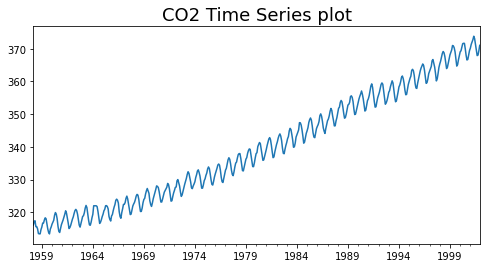

In [13]:
# Plot the time series
co2.plot(figsize=(8, 4))
plt.title('CO2 Time Series plot', 
          fontsize=18)
plt.show()

The **time series** has an **increasing trend** and a **seasonality pattern**. 

### Time Series Decomposition in Trend, Seasonality, and Noise

**STL decomposition** allows visualizing the three distinct components of the time series: trend, seasonality, and noise. 
Understanding the structure of these components could help in building a forecast method.

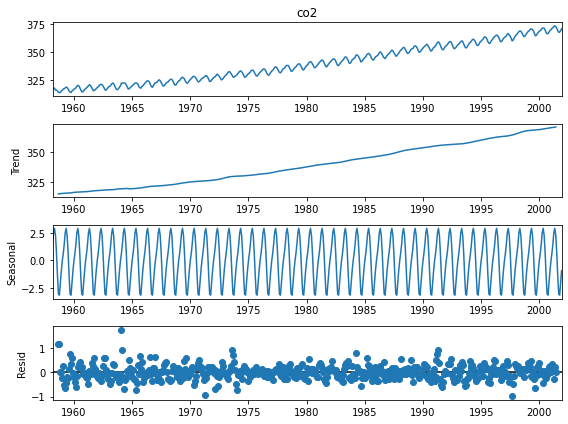

In [14]:
# Perform the STL decomposition 
decomposition = sm.tsa.\
             seasonal_decompose(
             co2, model='additive')

# Visualize the Trend, Seasonal
# and Residual components
rcParams['figure.figsize'] = 8, 6
fig = decomposition.plot()
plt.show()

There is a clear **upwards trend of the data**, along with its **yearly seasonality**. 

Below it is created a **dataframe** containing the time series components: trend, seasonal and residual. 

In [15]:
# Create a dataframe with time series components: trend, seasonal and residual
co2_decomp = pd.DataFrame({'resid': decomposition.resid, 
                         'trend': decomposition.trend, 
                         'seasonal': decomposition.seasonal},
                       index = co2.index)

In [16]:
# Print the first rows from the dataframe with STL decomposition
print(co2_decomp.head(12))
print(co2_decomp.tail(12))

               resid       trend  seasonal
1958-03-01       NaN         NaN  1.441376
1958-04-01       NaN         NaN  2.509278
1958-05-01       NaN         NaN  2.913993
1958-06-01       NaN         NaN  2.270436
1958-07-01       NaN         NaN  0.732631
1958-08-01       NaN         NaN -1.329174
1958-09-01  1.173979  315.375000 -3.048979
1958-10-01  1.154518  315.421181 -3.150699
1958-11-01 -0.000235  315.478125 -2.052890
1958-12-01  0.009397  315.615278 -0.924675
1959-01-01 -0.224314  315.752778 -0.028464
1959-02-01  0.244639  315.788194  0.667166
               resid       trend  seasonal
2001-01-01 -0.012786  370.216250 -0.028464
2001-02-01  0.323459  370.334375  0.667166
2001-03-01  0.166957  370.451667  1.441376
2001-04-01 -0.296987  370.562708  2.509278
2001-05-01  0.216007  370.670000  2.913993
2001-06-01  0.001647  370.787917  2.270436
2001-07-01       NaN         NaN  0.732631
2001-08-01       NaN         NaN -1.329174
2001-09-01       NaN         NaN -3.048979
2001-10-01 

This is a **monthly time series**, so the **first and last six lag values of the residual and trend** are **not known numbers**
(**NaN** values), but the **seasonal component has values**.

### Check if residual is stationary - apply Dickey-Fuller test

We define the **null and alternate hypotheses**:

**H0**: The time series is regarded as **non-stationary**. 
    
**HA**: The time series is regarded as **stationary**.

In [17]:
# Define a function to apply the Dicky Fuller test

def DF_Test(ts):
    """Apply augumented Dicky Fuller test to 
       check if residual is stationary"""
    
    # Perform augumented Dickey-Fuller test
    stationary = adfuller(ts)
    
    # Print the results
    print('D-F statistic = ' + \
          str(stationary[0]))
    print('p-value = ' + \
          str(stationary[1]))
    print('number of lags used = ' + \
          str(stationary[2]))
    print('Critical value at 5% confidence = ' + \
          str(stationary[4]['5%']))
    print('Critical value at 10% confidence = ' + \
          str(stationary[4]['10%'])) 

In [18]:
# Apply the Dicky Fuller test
DF_Test(co2_decomp.resid[6:-6])

D-F statistic = -11.725427922204883
p-value = 1.3812764708766198e-21
number of lags used = 9
Critical value at 5% confidence = -2.8672917032172953
Critical value at 10% confidence = -2.5698334393109095


The **Dickey-Fuller statistic has a big value**. 

It also has **large values for the 5% and 10% cutoffs**

The **p-value is very small**. 
 
We can **reject the null hypothesis** and conclude that the **residual time series is stationary**.

### Compute and plot the Autocorrelation (ACF) and Partial Autocorrelation (PACF) values

**Autocorrelation** is a measure of the **correlation between successive values in a time series**. It is used the Pearson’s 
correlation coefficient, with values **between -1 and 1** that describes a **negative or positive correlation**. A value of
**zero** indicates **no correlation**.

Next we compute and plot the ACF and PACF for the CO2 residual series.

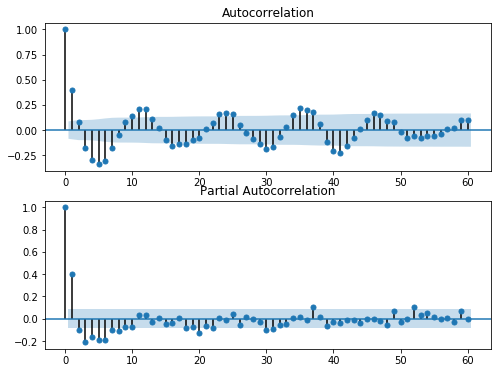

In [19]:
# Compute and plot the ACF and PACF 
# for the CO2 residual series

# Define subplots
fig, ax = plt.subplots(2,1)

# Compute and plot the ACF
fig = splt.plot_acf(
           co2_decomp.resid[6:-6], 
           lags = 60, 
           ax=ax[0])

# Compute and plot the PACF
fig = splt.plot_pacf(
           co2_decomp.resid[6:-6],
           lags = 60, 
           ax=ax[1])
plt.show()

The **ACF plot**:
- has **one significant positive lag** and some **negative lags, marginally significant** 
- has **continued periodicity**, although **most of the lags are not significant**

The **PACF plot**:
- has also **one significant positive lag** and a **few negative significant spikes with gradual decay** 
- shows **signs of slightly periodicity** that was not quite eliminated

The results of the ACF and PACF plots could be used as a starting point to narrow down a few potential parameters for the 
seasonal ARIMA model.

### Select the seasonal ARIMA model (SARIMA)

The **STL decomposition** showed that the **CO2 time series has a defined seasonality**, so it will be used a **SARIMA model**
(Seasonal AutoRegressive Integrated Moving Averages).

The model is represented as **SARIMA(p,d,q)x(P,D,Q,s)** where: 
- the **parameters (p, d, q) are the non-seasonal parameters** 
- the **parameters (P, D, Q) are applied to the seasonal component**

Detailed:
- **p and seasonal P**: number of autoregressive terms (lags of the stationarized series)
- **d and seasonal D**: differencing that must be done to stationarize series
- **q and seasonal Q**: number of moving average terms (lags of the forecast errors)
- **s**: seasonal length in the data (**periodicity**), with a value of 12 for yearly periods 

### Grid search - SARIMA model parameter selection

The **grid search** is used to **iteratively explore** different **combinations of parameters**. 

For **each combination** of parameters, it is **fitted** a new seasonal ARIMA **model** with the **SARIMAX() function** from the statsmodels module 
<a href="https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html">SARIMAX</a> and assess its
overall quality. 

We'll use the **ACF and PACF plots** as a starting point to **narrow down** a few **potential parameters**: 
- both **ACF and PACF** have **1 positive significant lag**, which suggests a **possible value of 1 for p and seasonal P**
- for **d and D, the value should be 1**, as first difference and seasonal difference (well defined seasonal patterns). 
- for **q and Q** could also be **selected 1** since there are few significant negative spikes and PACF decay is more
gradual
- the **term s is equal to 12** since it is a yearly periodicity

These characteristics suggest a **potential parameter range between (0, 2)** for p,d,q parameters to **start the grid search**.

In [20]:
# Set the range for p, d, q parameters
# to take any value between 0 and 2
p = range(0, 2)
d = range(0, 2)
q = range(0, 2)

# Create list of all parameter combos
pdq = list(itertools.product(p, d, q)) 

# Generate all different combinations
# of seasonal p, d, q
seasonal_pdq = [(x[0], x[1], x[2], 12) \
               for x in list(itertools.\
               product(p, d, q))]    

The above **combinations of parameters** will be used for **grid search (hyperparameter optimization)** for **model selection**. 

The **AIC (Akaike Information Criterion)** is a metric used to **compare models with different values of p, d, q**.

**A lower AIC score** indicates a **more predictive model**. 

Below it is set up a **grid search** to:
- **test** a number of **different parameter combinations**
- **list** the SARIMA model pipeline that tested **each combination**
- **print** the corresponding **AIC scores** 

Some parameter combinations may lead to displaying warning or error messages during the iterative process.
An advantage of SARIMA model is that it allows to ignore them, in order to avoid an overload of warning/error messages.

In [21]:
# Disable warning messages
warnings.filterwarnings("ignore")               

# SARIMA model pipeline
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(co2,
                                            order=param,                     # specifies the (p,d,q) parameters
                                            seasonal_order=param_seasonal,   # specifies the (P,D,Q,s) seasonal component
                                            enforce_stationarity=False,      # enforce_stationarity in the AR comp (False)
                                            enforce_invertibility=False)     # enforce_invertibility in the MA comp (False)

            results = mod.fit()

            print('SARIMAX{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMAX(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7612.583429881011
SARIMAX(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.343624044102
SARIMAX(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1854.8282341411793
SARIMAX(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.711172764109
SARIMAX(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320058
SARIMAX(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1056.2878474543522
SARIMAX(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1361.6578977897923
SARIMAX(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.7647912740742
SARIMAX(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6881.048754117362
SARIMAX(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6072.662327700222
SARIMAX(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1379.194106730522
SARIMAX(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1241.4174716868783
SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1094.6679064616128
SARIMAX(0, 0, 1)x(1, 0, 1, 12)12 - AIC:782.5930728936784
SARIMAX(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1119.5957893625127
SARIMAX(0, 0, 1)x(1, 1, 1, 12)12 - AIC:807.0912988455857
SARIMAX(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1675.808692302429
SARIMAX(0, 1, 0)x(0, 0,

The output of above shows that **SARIMAX(1, 1, 1 ) x (1, 1, 1, 12)** yields the **lowest AIC value of 277.78**.

We'll use **this model to fit the time series data**.

### Fitting the seasonal ARIMA model

The grid search identified the set of parameters that produces the **best fitting model** for the time series data. Using these 
optimal parameter values, it is **computed the SARIMAX model** and are **displayed statistics** that can help to understand the model.
In this case it is used the entire range of data to fit the model.

In [22]:
# Compute the SARIMAX model
# using the best parameters 

mod = sm.tsa.statespace.\
      SARIMAX(
         co2,
         order=(1, 1, 1),                 
         seasonal_order=(1, 1, 1, 12),    
         enforce_stationarity=False,
         enforce_invertibility=False)

# Get results
results = mod.fit()

# Print statistics
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3179      0.092      3.443      0.001       0.137       0.499
ma.L1         -0.6255      0.076     -8.177      0.000      -0.775      -0.476
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8766      0.026    -33.754      0.000      -0.927      -0.826
sigma2         0.0971      0.004     22.638      0.000       0.089       0.106


The **coefficients** have a **p-value lower or close to 0.05**, the **confidence intervals** are **statistically significant** 
(do not include zero) and the **standard errors** are **very small** comparing with the coefficient themselves, so we'll 
**retain them all in the model**.

### Model diagnostics

We'll run **model diagnostics to investigate** the behavior of the **SARIMA model**.

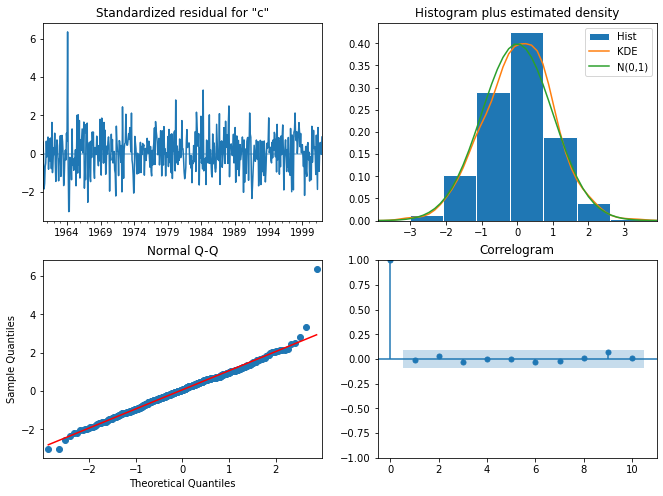

In [23]:
# Generate model diagnostics
results.plot_diagnostics(figsize=(11, 8))
plt.show()

The observations below suggest that the **residuals** are **stationary**, **uncorrelated** and **normally distributed with 
zero mean**: 

- The **residuals** in the top left plot **have a stationary distribution**. They don’t display any obvious seasonality and 
appear to be white noise. 
- The **autocorrelation plot** on the bottom right, shows that the time series **residuals have low correlation** with 
lagged versions of itself.
- **The histogram** in the top right shows a **normal distribution**. Also, the **KDE** line follows closely with 
the N(0,1) **line for normal distribution** with **mean 0** and **standard deviation of 1**. 
- **The QQ-plot** on the bottom left shows that the ordered distribution of **residuals follows** the linear trend of the **standard normal distribution**. 

These **observations confirm** that the **SARIMA model used** is a **good fit** for the **CO2 time series** and **can be used for forecasting**.

Next, we will use the SARIMA model to answer the following questions:

## 1. How do the One-step ahead forecasts look starting with 1995?

**One-step ahead forecasts** are generated at **each point** using the **full history up to that point**.

**The predicted values** are **compared** with **real values**, to understand the **accuracy** of the **forecasts**. 

**The forecast** is set to **start from 1995-01-01**. 

In [24]:
# Compute One-step ahead forecasts and 
# confidence intervals starting 
# with 1995-01-01

# Predict one-step ahead forecasts 
# using parameter dynamic=False
pred = results.get_prediction(
        start=pd.to_datetime('1995-01-01'),
        dynamic=False)

# Get confidence intervals for forecasts 
# default alpha=0.05 for 95% ci
pred_ci = pred.conf_int()

### One-step ahead Forecasted values for entire CO2 time series

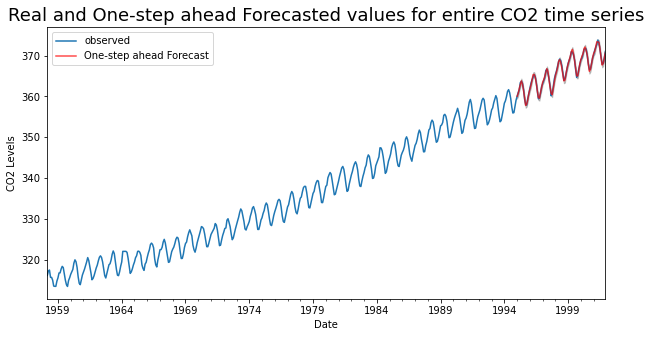

In [25]:
# Plot the Real and One-step ahead 
# forecasted values for the 
# entire time series range 

# Plot real values
ax = co2.plot(
         label='observed', 
         figsize=(10, 5))

# Plot One-step ahead forecasted values
pred.predicted_mean.plot(
         ax=ax, 
         label='One-step ahead Forecast', 
         color='r', 
         alpha=.7)

# Fill the area between curves
ax.fill_between(
         pred_ci.index,
         pred_ci.iloc[:, 0],
         pred_ci.iloc[:, 1], 
         color='k', 
         alpha=.2)

# Set the labels and title
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.title(
    'Real and One-step ahead Forecasted values for entire CO2 time series', 
     fontsize=18)
plt.legend()
plt.show()

For a closer look at how **forecasted** values **match** the **real** values, we **slice the date index of the time series**, 
**starting** with the **year 1985**.

### One-step ahead Forecasted values for a slice starting with 1985

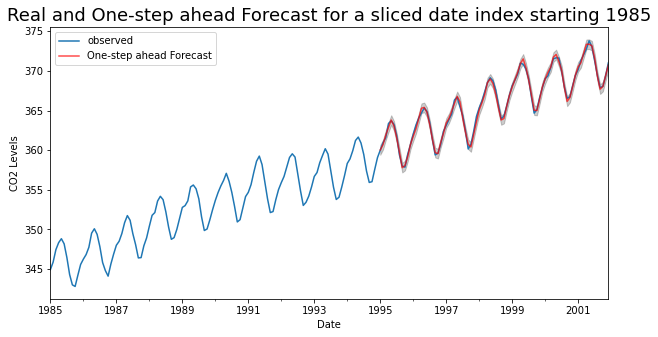

In [26]:
# Plot the Real and One-step ahead
# forecasted values for a sliced
# date index starting with 1985

# Plot real values
ax = co2['1985':].plot(
        label='observed', 
        figsize=(10, 5))

# Plot One-step ahead forecasted values
pred.predicted_mean.plot(
        ax=ax, 
        label='One-step ahead Forecast', 
        color='r', 
        alpha=.7)

# Fill the area between curves
ax.fill_between(
        pred_ci.index,
        pred_ci.iloc[:, 0],
        pred_ci.iloc[:, 1], 
        color='k', 
        alpha=.2)

# Set the labels and title
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.title(
    'Real and One-step ahead Forecast for a sliced date index starting 1985', 
     fontsize=18)
plt.legend()
plt.show()

Overall, __one-step ahead forecasts seem to align with the real values quite well, showing an overall increase trend.__

In [27]:
# Calculate Mean Squared Error of 
# one-step ahead forecasts

# Compute the predicted one-step ahead 
# forecasted values
co2_forecasted = pred.predicted_mean

# Compute the true values
co2_real = co2['1995-01-01':]

# Compute and print the mean square error
mse = ((co2_forecasted - co2_real) ** 2).\
          mean()
print('The MSE of the forecasts is {}'.\
          format(round(mse, 2)))

The MSE of the forecasts is 0.09


The __MSE of the one-step ahead forecasts__ yields a value of __0.09__, very close to 0 which indicates a __good accuracy of the forecasts__.

### 2. Do the Dynamic forecasted values match the real ones starting with 1995?

**Dynamic forecasts** use **information** from the time series **only up to a certain point**, then forecasts are generated using 
values from **previous forecasted points**.

Below, are computed the **dynamic forecasts and confidence intervals starting with 1995-01-01**.

In [28]:
# Compute Dynamic forecasts and 
# confidence intervals starting 
# with 1995-01-01

# Predict dynamic forecasts
# parameter dynamic=True
pred_dynamic = results.get_prediction(
     start=pd.to_datetime('1995-01-01'),
     dynamic=True, 
     full_results=True)

# Get confidence intervals
pred_dynamic_ci = pred_dynamic.conf_int()

Below are plotted the dynamic forecasted values vs real values, using a sliced date index starting with 1985.

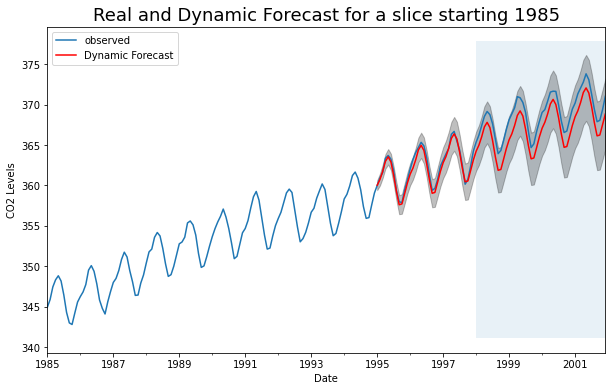

In [29]:
# Plot the Real vs Dynamic forecasted
# values for a slice 
# starting with 1985

# Plot real values starting
ax = co2['1985':].plot(
        label='observed',
        figsize=(10, 6))

# Plot Dynamic forecasted values
pred_dynamic.predicted_mean.plot(
        label='Dynamic Forecast',
        color='r',
        ax=ax)

# Fill the area between curves
ax.fill_between(
        pred_dynamic_ci.index,
        pred_dynamic_ci.iloc[:, 0],
        pred_dynamic_ci.iloc[:, 1], 
        color='k', 
        alpha=.25)

ax.fill_betweenx(
        ax.get_ylim(), 
        pd.to_datetime('1998-01-01'), 
        co2.index[-1],
        alpha=.1, 
        zorder=-1)

# Set the labels and title
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.title(
    'Real and Dynamic Forecast for a slice starting 1985',
     fontsize=18)
plt.legend(loc='upper left')
plt.show()

The overall **predictions are accurate for dynamic forecasts**. 

The **forecasted values match closely** the **real values**, and are well **within the confidence intervals of the forecast**.

Next it is **computed** also the **MSE** to **quantify the predictive performance of the dynamic forecasts**.

In [30]:
# Calculate Mean Squared Error of 
# dynamic forecasts

# Compute the predicted dynamic 
# forecasted values
co2_forecasted = pred_dynamic.predicted_mean

# Compute the true values
co2_real = co2['1995-01-01':]

# Compute the mean square error
mse = ((co2_forecasted - co2_real) ** 2).\
         mean()
print('The MSE of the forecasts is {}'.\
         format(round(mse, 2)))

The MSE of the forecasts is 2.01


The **dynamic forecasts** yield an **MSE of 2.01**. It is **slightly higher than the one-step ahead**.

This is **expected** since **dynamic forecasts rely on less historical data from the time series**.

**Conclusion** for one-step ahead and dynamic forecasts:
- Both **one-step ahead** and **dynamic forecasts** confirm the **validity of the SARIMA model** selected.

### 3. How do the Future forecasts look like for the CO2 time series?

We'll forecast values for **200 steps ahead in future**.

In [31]:
# Get forecast 200 steps ahead in future
pred_uc = results.get_forecast(steps=200)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

### Future Forecasted values for entire CO2 time series

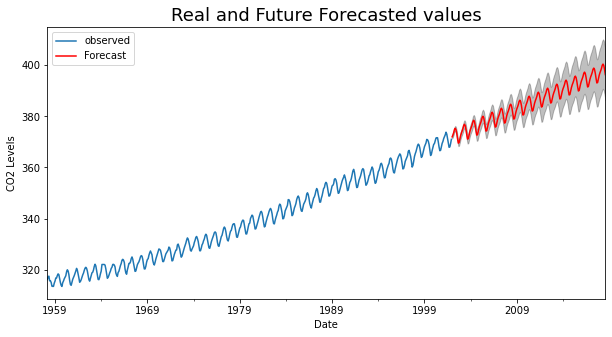

In [32]:
# Plot the Real and 
# Forecasted Future values
# for entire CO2 time series

# Plot real values
ax = co2.plot(
         label='observed', 
         figsize=(10, 5))

# Plot future forecasted values
pred_uc.predicted_mean.plot(
        ax=ax, 
        label='Forecast', 
        color='r')

# Fill the area between curves
ax.fill_between(
        pred_ci.index,
        pred_ci.iloc[:, 0],
        pred_ci.iloc[:, 1], 
        color='k', 
        alpha=.25)

# Set the labels and title
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.title(
    'Real and Future Forecasted values', 
     fontsize=18)
plt.legend(loc='upper left')
plt.show()

#### Future Forecasted values for a slice starting 1990

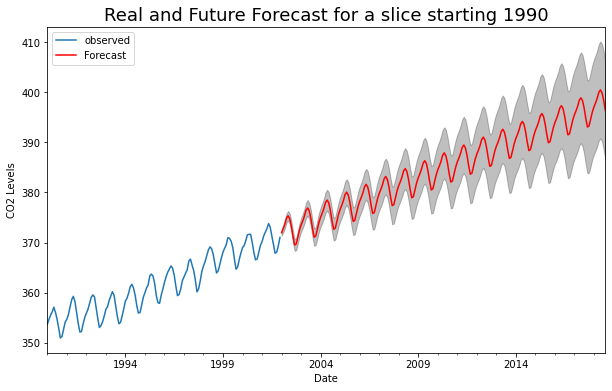

In [33]:
# Plot the Real and 
# Future forecasted values 
# for a slice 
# starting with 1990

# Plot real values
ax = co2['1990':].plot(
          label='observed', 
          figsize=(10, 6))

# Plot future forecasted values
pred_uc.predicted_mean.plot(
          ax=ax, 
          label='Forecast', 
          color='r')

# Fill the area between curves
ax.fill_between(
          pred_ci.index,
          pred_ci.iloc[:, 0],
          pred_ci.iloc[:, 1], 
          color='k', 
          alpha=.25)

# Set the labels and title
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.title(
    'Real and Future Forecast for a slice starting 1990', 
     fontsize=18)
plt.legend(loc='upper left')
plt.show()

The **future forecasts** show that the **time series is expected to continue increasing at a steady pace**.

The **confidence intervals** generated by the model **grow larger as the values move further out into the future**. <br>
**This is expected**, as there is **less confidence** in the **values further forecasted into the future**.

## Summary

- The CO2 data was **prepared** by **resampling** and **filling in missing values**. 
<br>

- **Exploratory Data Analysis** was done using **visualization** and **STL decomposition**. 
<br>

- The **results** of the **ACF and PACF plots** were used as a **starting point** to **narrow down** a few **potential 
parameters** for the **seasonal ARIMA model**.
<br>
- It was applied a **grid search** to identify the **best model parameters** for **fitting the model** to the time series. 
Finding a good SARIMA model allowed a better understanding of the time series and to forecast future points. 
<br>
- The **SARIMA model** was used to produce **one-step ahead** and **dynamic forecasts** that confirmed the validity of the 
model. 
<br>
- The **plots** of the **forecasted vs real values** confirmed that overall **forecasts were accurate** for both **one-step ahead** and **dynamic forecasts**. 
<br>
- The **future forecasts** indicated that the **time series is expected to continue increasing at a steady pace**.